# Analyzing genotype-phenotype maps
Example and homework for Genome Sciences 541, by Jesse Bloom, June-2019.

The questions in this notebook are due by **5 PM on Thursday June 13**.

## Import Python modules

In [1]:
import matplotlib.pyplot as plt
plt.ion()

import pandas as pd

import scipy.optimize

## Create an additive genotype-phenotype map
Define a class that sets up an additive model for phenotypes and randomly assigns effects to each mutation at each site:

In [2]:
class AdditiveModel:
    """Additive genotype-phenotype model.
    
    Parameters
    ----------
    alphabet : list
        List of characters in the alphabet for the sequences.
    wtseq : str
        The wildtype sequence.
    seed : int
        The random number seed for initializing model parameters
    
    Attributes
    ----------
    alphabet : list
        List of characters in the alphabet for the sequences.
    wtseq : str
        The wildtype sequence.
    seqlength : int
        Length of sequences.
    wtpheno : float
        Phenotype of wildtype sequence.
    site_effects : dict
        Keyed by `(site, a)` where `site` is site in 0, 1, ... numbering and
        `s` is each possible letter in alphabet; values are effects of mutations.
    """
    
    def __init__(self,
                 alphabet,
                 wtseq,
                 seed=1):
        """See main class docstring for how to initialize."""
        self.alphabet = alphabet
        self.wtseq = wtseq
        for a in wtseq:
            if a not in alphabet:
                raise ValueError(f"wtseq contains character not in alphabet: {a}")
        self.seqlength = len(wtseq)
        
        scipy.random.seed(seed)
        self.wtpheno = scipy.random.normal(2)
        self.site_effects = {}
        for r, a_wt in enumerate(self.wtseq):
            for a in self.alphabet:
                if a == a_wt:
                    self.site_effects[(r, a)] = 0
                else:
                    self.site_effects[(r, a)] = scipy.random.normal(-1, 2)
                    
    def muteffects_table(self):
        """Table of effects of all mutations
        
        Returns
        -------
        pandas DataFrame
            Columns give site, wildtype identity, mutation, and its effect.
        """
        return (pd.Series(self.site_effects)
                .rename_axis(['site', 'mutation'])
                .reset_index(name='muteffect')
                .assign(wildtype=lambda x: x['site'].apply(lambda r: self.wtseq[r]))
                [['site', 'wildtype', 'mutation', 'muteffect']]
                .query('wildtype != mutation')
                .reset_index(drop=True)
                )
    
    def pheno(self, seq):
        """Returns phenotype of sequence.
        
        Parameters
        ------------
        seq : str
            A sequence.
            
        Returns
        ---------
        float
            The phenotype.
        """
        return sum(self.site_effects[(r, a)] for r, a in enumerate(seq)) + self.wtpheno
    
    def all_seqs_phenos(self):
        """Get all possible sequences and their phenotypes.
        
        Returns
        ---------
        dict
            Keyed by all possible sequences, values are their phenotypes.
        """
        # recursive function to build all sequences
        def _add_letter(seqlist):
            if len(seqlist[0]) == self.seqlength:
                return seqlist
            newseqlist = []
            for seq in seqlist:
                for a in self.alphabet:
                    newseqlist.append(seq + a)
            return _add_letter(newseqlist)
            
        allseqs = _add_letter(self.alphabet)
        return {seq: self.pheno(seq) for seq in allseqs}

Now create an additive model of binary sequences of letters `0` and `1` where the wildtype sequence is `0000`:

In [3]:
binary_additive_model = AdditiveModel(['0', '1'], '0000')

Here are the effects of mutations:

In [4]:
binary_additive_model.muteffects_table()

,site,wildtype,mutation,muteffect
0,0,0,1,-2.223513
1,1,0,1,-2.056344
2,2,0,1,-3.145937
3,3,0,1,0.730815


Here are all the genotypes and their phenotypes in a dict:

In [5]:
binary_additive_gp = binary_additive_model.all_seqs_phenos()
binary_additive_gp

{'0000': 3.6243453636632417,
 '0001': 4.3551606223125985,
 '0010': 0.47840811935090066,
 '0011': 1.2092233780002575,
 '0100': 1.5680018591363303,
 '0101': 2.2988171177856875,
 '0110': -1.5779353851760103,
 '0111': -0.8471201265266535,
 '1000': 1.4008325363630911,
 '1001': 2.131647795012448,
 '1010': -1.7451047079492499,
 '1011': -1.014289449299893,
 '1100': -0.6555109681638207,
 '1101': 0.07530429048553611,
 '1110': -3.8014482124761617,
 '1111': -3.070632953826805}

Here is the same in a nice data frame format:

In [6]:
binary_additive_gp_df = (
    pd.Series(binary_additive_gp)
    .rename_axis('genotype')
    .reset_index(name='phenotype')
    )
binary_additive_gp_df

,genotype,phenotype
0,0000,3.624345
1,0001,4.355161
2,0010,0.478408
3,0011,1.209223
4,0100,1.568002
5,0101,2.298817
6,0110,-1.577935
7,0111,-0.847120
8,1000,1.400833
9,1001,2.131648


Here is the distribution of phenotypes:

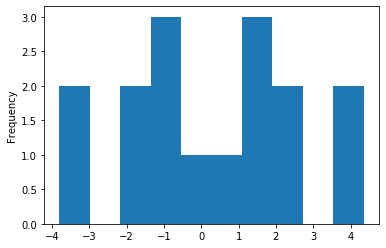

In [7]:
binary_additive_gp_df['phenotype'].plot.hist()

## Fit additive parameters in binary map
We will write a fitting function.
We will use the general curve-fitting function [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) because eventually (even if not in this homework), we'd like to extend to fitting non-linear genotype-phenotype maps.

For our specific binary additive phenotype-genotype map above, we will be fitting five parameters:

  - the phenotype of the wildtype
  
  - the effect of the mutation from `0` to `1` at each of the four sites in the sequence
  
So initialize a vector of parameters of the appropriate length, initially setting all to zero.
Each entry in the vector represents one of the aforementioned parameters (in order).

In [8]:
params0 = scipy.zeros(1 + binary_additive_model.seqlength)
params0

array([0., 0., 0., 0., 0.])

Now we define a function that returns the squared difference between the actual and predicted phenotypes.
Note that this function works **only for the specific example above**, where there is a binary genotype-phenotype map and the wildtype sequence is all `00...00`:

In [9]:
def func_additive_binary(params):
    """Fit of `params` to `binary_additive_gp`."""
    diff = 0
    for seq, pheno in binary_additive_gp.items():
        predict_pheno = params[0]
        for r, a in enumerate(seq):
            if a == '1':
                predict_pheno += params[r + 1]
        diff += (pheno - predict_pheno)**2
    return diff

If we perfectly fit the map, the return value of this function should be zero.
Here it is for our initial guess:

In [10]:
func_additive_binary(params0)

79.64066968804582

Now let's fit the optimal parameters:

In [11]:
fit = scipy.optimize.minimize(func_additive_binary, params0)
params = fit.x
print(params)

[ 3.62434536 -2.22351283 -2.0563435  -3.14593724  0.73081526]


How good is this fit?
Recall that the first element of the fit is the wildtype phenotype.
Let's compare:

In [12]:
print(f"Actual wildtype phenotype: {binary_additive_model.wtpheno}")
print(f"Fit wildtype phenotype: {params[0]}")

Actual wildtype phenotype: 3.6243453636632417
Fit wildtype phenotype: 3.6243453564867836


Now let's look at the effects of the mutations.
Recall that after the first element of the fit, each element is the value of the mutation from `0` to `1` at each site.
Here are the actual values:

In [13]:
binary_additive_model.muteffects_table()

,site,wildtype,mutation,muteffect
0,0,0,1,-2.223513
1,1,0,1,-2.056344
2,2,0,1,-3.145937
3,3,0,1,0.730815


Here are the fit values:

In [14]:
params[1 : ]

array([-2.22351283, -2.0563435 , -3.14593724,  0.73081526])

Or more nicely formatted:

In [15]:
binary_additive_muteffects_fit = (
    binary_additive_model.muteffects_table()
    .assign(fit_muteffect=params[1: ])
    )
binary_additive_muteffects_fit

,site,wildtype,mutation,muteffect,fit_muteffect
0,0,0,1,-2.223513,-2.223513
1,1,0,1,-2.056344,-2.056344
2,2,0,1,-3.145937,-3.145937
3,3,0,1,0.730815,0.730815


Plotting the correlation:

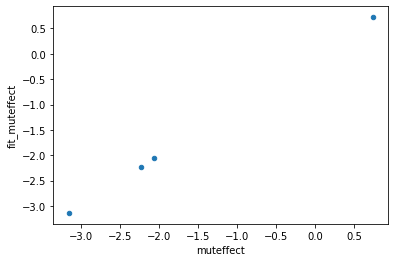

In [16]:
binary_additive_muteffects_fit.plot.scatter('muteffect', 'fit_muteffect')

## Homework question 1
Above we fit a binary map with a wildtype sequence of all `00.00`.
But we could make a more general map, say with nucleotide characters and some other wildtype sequence:

In [17]:
additive_model = AdditiveModel(['A', 'C', 'G', 'T'], 'ATGC')

It would again have some mutational effects:

In [18]:
additive_model.muteffects_table()

,site,wildtype,mutation,muteffect
0,0,A,C,-2.223513
1,0,A,G,-2.056344
2,0,A,T,-3.145937
3,1,T,A,0.730815
4,1,T,C,-5.603077
5,1,T,G,2.489624
6,2,G,A,-2.522414
7,2,G,C,-0.361922
8,2,G,T,-1.498741
9,3,C,A,1.924216


And some wildtype phenotype:

In [19]:
additive_model.wtpheno

3.6243453636632417

And phenotypes for each genotype:

In [20]:
additive_gp_df = (
    pd.Series(additive_model.all_seqs_phenos())
    .rename_axis('genotype')
    .reset_index(name='phenotype')
    )
print('Here are the first few genotypes and their phenotypes:')
additive_gp_df.head()

Here are the first few genotypes and their phenotypes:


,genotype,phenotype
0,AAAA,3.756963
1,AAAC,1.832747
2,AAAG,-3.287535
3,AAAT,0.187912
4,AACA,5.917455


And if you generalize the fitting function above, you can determine the mutational effects in this additive model.

But that is **not** the homework.
Instead I have generated a genotype-phenotype map just like the one shown above (with the same wildtype sequence of `ATGC`), but **with a different random number seed.**
This map is in [hw_gp_list.csv](hw_gp_list.csv), which we read in here:

In [21]:
hw_additive_gp_df = pd.read_csv('hw_gp_list.csv')
print('Here are the first few genotypes and their phenotypes:')
hw_additive_gp_df.head()

Here are the first few genotypes and their phenotypes:


,genotype,phenotype
0,AAAA,-5.160712
1,AAAC,0.172790
2,AAAG,-1.056697
3,AAAT,-0.308053
4,AACA,-3.280548


Your homework question is to generalize the fitting function above to determine the mutational effects for this genotype-phenotype map.
Turn them in as a dataframe giving the effect of each mutation at each site in the format of the similar data frames above.
Also turn in the code you use to do this.